In [54]:
import numpy as np                   
import pandas as pd   
import matplotlib.pyplot as plt    
import seaborn as sns
import sys
import nltk  
nltk.download('stopwords')          
from nltk.corpus import stopwords
import json
import fasttext
import umap
import random
import hdbscan
import random
from functools import partial

from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chait\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
# THIS FUNCTION TAKES A CSV FILE FROM A GITHUB URL AND READS IT INTO A PANDAS DATA FRAME
import pandas as pd

def read_file(url):

    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """

    url = url + "?raw=true"
    df = pd.read_csv(url)
    return df


# READ FILE FROM GITHUB REPO 
# CHANGE THE URL TO YOUR DATA LOCATION!
url = "https://github.com/Chaichaithra/Reddit-Clusters/blob/main/grouped_subreddits.csv"

df = read_file(url)

In [69]:
#df = pd.read_csv("C:/Users/chait/Desktop/Masterthesisgit/grouped_subreddits.csv")

In [4]:
# removing everything except alphabets`
df['clean_doc'] = df['title'].str.replace("[^a-zA-Z#]", " ")
# removing null fields
df = df[df['clean_doc'].notnull()]
# removing short words
df['clean_doc'] = df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# make all text lowercase
df['clean_doc'] = df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-4-e4cdc9c278ad>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_doc'] = df['title'].str.replace("[^a-zA-Z#]", " ")


In [5]:
#tfidf vectors 

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['like','january','thread','would','first','time','good', 'moderator', 'announcement','daily','discussion','baiting','titles','title','spam','upvote','allowed','know','make','best','weekly','think','year','years'])
# data is from washingtonpost, and it occurs heavily in every article, thus added to stop words
# tokenization
tokenized_doc = df['clean_doc'].apply(lambda x: x.split())
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
#print(tokenized_doc)
# de-tokenization
detokenized_doc = []
for i in range(len(tokenized_doc)):
    if i in tokenized_doc:
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)
#print(detokenized_doc)
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer of scikit learn
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = vectorizer.fit_transform(detokenized_doc)
#print(X) # check shape of the document-term matrix
terms = vectorizer.get_feature_names()
#print(X)

In [8]:
all_intents = list(df['clean_doc'])
len(all_intents)

1096

In [9]:

from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('all-mpnet-base-v2')


In [10]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [11]:
embeddings_st1 = embed(model_bert, 'sentence transformer', all_intents)


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [12]:
print(embeddings_st1.shape)
print(type(embeddings_st1[0]))
print(embeddings_st1)

(1096, 768)
<class 'numpy.ndarray'>
[[ 0.00623906  0.12168376  0.0051742  ...  0.02923936 -0.04030319
  -0.05051731]
 [ 0.05088096  0.01648959 -0.03926764 ...  0.04371506 -0.01834014
   0.01838004]
 [ 0.03596247  0.04397437 -0.00123556 ...  0.00864509  0.00054365
  -0.02788111]
 ...
 [ 0.07277388  0.00636981 -0.00602381 ...  0.0372994  -0.01180758
  -0.02630982]
 [ 0.08525436  0.09003883  0.00709792 ... -0.02982    -0.01349628
  -0.02587245]
 [ 0.03386794  0.0239526  -0.00670573 ...  0.03719423 -0.00248446
   0.01994923]]


In [13]:
#fasttext 

In [14]:
model = fasttext.train_unsupervised('C:/Users/chait/Desktop/MT/wordembed.txt') 
f = []                                               
for i in df['clean_doc']:   
    f.append(model.get_sentence_vector(i))

w_train = np.array(f)    
print(w_train)

#df['vec'] = df['clean_doc'].apply(lambda x: model.get_sentence_vector(x))

[[-0.0881656   0.13563462 -0.10791531 ...  0.0182694  -0.00114014
   0.06861518]
 [-0.10003066  0.15038513 -0.11576287 ... -0.00309646 -0.00898204
   0.07826889]
 [-0.0746062   0.12895048 -0.09622978 ... -0.0151559  -0.01172664
   0.06314418]
 ...
 [-0.0926016   0.14789145 -0.10262422 ...  0.00556308 -0.01544046
   0.07023936]
 [-0.08494918  0.11404093 -0.09044515 ...  0.0223351  -0.00949466
   0.0606515 ]
 [-0.06716403  0.11463793 -0.09544742 ... -0.00294055 -0.00176887
   0.05810364]]


In [15]:
def generating_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [16]:
def label_clusters(clusters, prob_threshold = 0.05): 
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    return label_count, cost

In [17]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search parameter space of clustering pipeline

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               and 'min_cluster_size' and values with
               corresponding lists or ranges of parameters to search
        num_evals: int, number of random parameter combinations to try

    Returns:
        df_result: pandas dataframe containing info on each evaluation
                   performed, including run_id, parameters used, label
                   count, and cost
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']
        
        clusters = generating_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     random_state=random_state)
    
        label_count, cost = label_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [18]:
def objective(params, embeddings, label_lower, label_upper): 
    clusters = generating_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = label_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [19]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generating_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [20]:
def combine_results(df_ground, cluster_dict):

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [21]:
def summarize_results(results_dict, results_df):
  
    summary = []

    for key, value in results_dict.items():
        ground_label = results_df['category'].values
        predicted_label = results_df[value[0]].values
        
        ari = np.round(adjusted_rand_score(ground_label, predicted_label), 3)
        nmi = np.round(normalized_mutual_info_score(ground_label, predicted_label), 3)
        loss = value[2].best_trial['result']['loss']
        label_count = value[2].best_trial['result']['label_count']
        n_neighbors = value[1]['n_neighbors']
        n_components = value[1]['n_components']
        min_cluster_size = value[1]['min_cluster_size']
        random_state = value[1]['random_state']
        
        summary.append([key, ari, nmi, loss, label_count, n_neighbors, n_components, 
                        min_cluster_size, random_state])

    df_final = pd.DataFrame(summary, columns=['Model', 'ARI', 'NMI', 'loss', 
                                              'label_count', 'n_neighbors',
                                              'n_components', 'min_cluster_size',
                                              'random_state'])
    
    return df_final.sort_values(by='NMI', ascending=False)

In [22]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):

    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

In [23]:
#tfidf
clusters_default = generating_clusters(X, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)

In [24]:
labels_def, cost_def = label_clusters(clusters_default)
print(labels_def)
print(cost_def)

17
0.5912408759124088


In [25]:
#sentence
clusters_default_sentence = generating_clusters(embeddings_st1, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)

In [26]:
labels_def, cost_def = label_clusters(clusters_default_sentence)
print(labels_def)
print(cost_def)

20
0.36313868613138683


In [27]:
#fasttext
clusters_default_fast = generating_clusters(w_train, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)

In [28]:
labels_def, cost_def = label_clusters(clusters_default_fast)
print(labels_def)
print(cost_def)

3
0.5903284671532847


In [ ]:
#hyper parameter tuning 

In [29]:
#tf-idf
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use = random_search(X, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
random_use.head(15)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
67,67,14,3,2,163,0.228102
33,33,14,3,2,163,0.228102
0,0,12,4,2,163,0.230839
7,7,14,4,2,154,0.261861
49,49,12,3,2,160,0.263686
5,5,15,5,2,160,0.285584
60,60,13,3,3,88,0.298358
54,54,12,4,3,83,0.318431
44,44,12,4,3,83,0.318431
34,34,13,5,3,77,0.329380


In [31]:
#fasttext
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use_fasttext = random_search(w_train, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
random_use_fasttext.head(15)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
64,64,12,3,3,4,0.017336
90,90,12,3,3,4,0.017336
51,51,15,6,5,3,0.056569
50,50,14,5,5,3,0.245438
37,37,14,5,5,3,0.245438
34,34,13,4,6,4,0.299270
1,1,14,6,2,142,0.304745
6,6,14,6,2,142,0.304745
27,27,13,3,2,160,0.317518
19,19,15,5,2,160,0.325730


In [33]:
#sentence

space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use_sentence = random_search(embeddings_st1, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
random_use_sentence.head(15)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
28,28,13,6,11,8,0.148723
0,0,13,3,12,9,0.159672
58,58,13,3,12,9,0.159672
1,1,13,3,13,9,0.164234
97,97,12,3,11,10,0.174270
66,66,12,3,11,10,0.174270
69,69,15,3,13,9,0.187956
40,40,15,3,13,9,0.187956
45,45,14,5,14,8,0.208029
42,42,14,5,14,8,0.208029


In [35]:
#Bayesian optimization with Hyperopt   

In [36]:
hspace = {  
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}       

label_lower = 30
label_upper = 100
max_evals = 100

In [37]:
best_params_use, best_clusters_use, trials_use = bayesian_search(X, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [03:32<00:00,  2.12s/trial, best loss: 0.15456204379562044]
best:
{'min_cluster_size': 8, 'n_components': 15, 'n_neighbors': 3, 'random_state': 42}
label count: 3


In [38]:
trials_use.best_trial

{'state': 2,
 'tid': 33,
 'spec': None,
 'result': {'loss': 0.15456204379562044, 'label_count': 3, 'status': 'ok'},
 'misc': {'tid': 33,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [33],
   'n_components': [33],
   'n_neighbors': [33]},
  'vals': {'min_cluster_size': [6], 'n_components': [12], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 3, 4, 11, 0, 15, 472000),
 'refresh_time': datetime.datetime(2022, 3, 4, 11, 0, 16, 988000)}

In [39]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [05:29<00:00,  3.29s/trial, best loss: 0.18065693430656934]
best:
{'min_cluster_size': 3, 'n_components': 5, 'n_neighbors': 4, 'random_state': 42}
label count: 92


In [40]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(w_train, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [04:36<00:00,  2.76s/trial, best loss: 0.16970802919708028]
best:
{'min_cluster_size': 3, 'n_components': 13, 'n_neighbors': 3, 'random_state': 42}
label count: 87


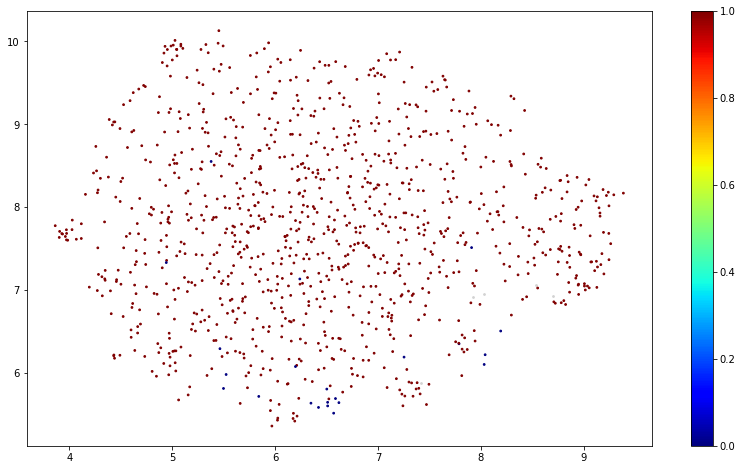

In [41]:
plot_clusters(X, best_clusters_use)

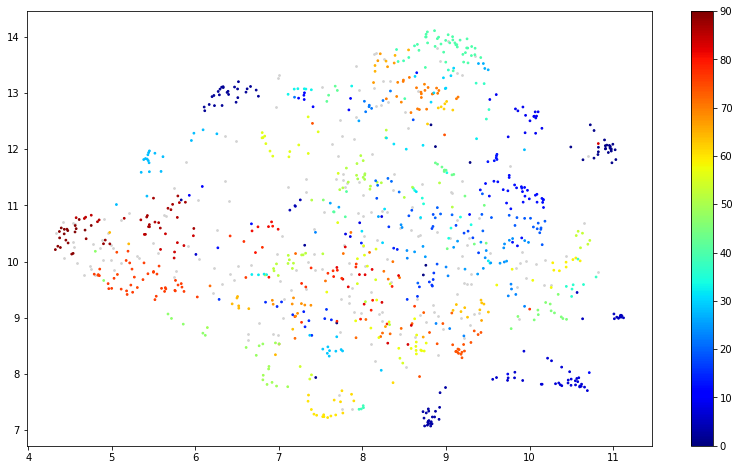

In [42]:
plot_clusters(embeddings_st1, best_clusters_st2)

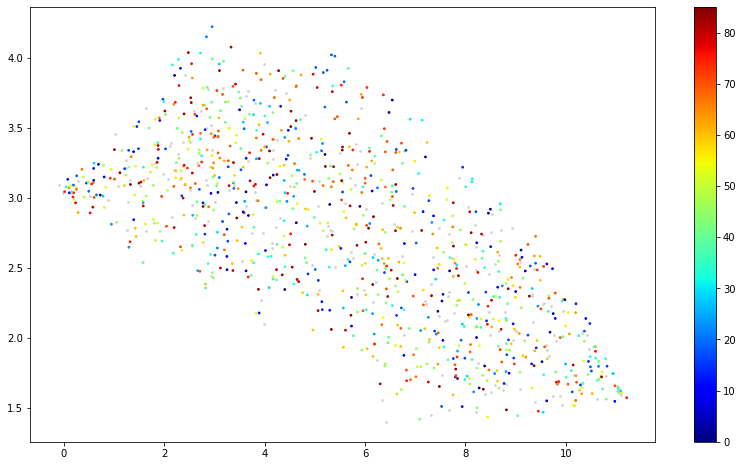

In [43]:
plot_clusters(w_train, best_clusters_st3)

In [ ]:
#comparing clustering using ground truth labels

In [70]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st2,
               'label_st2':  best_clusters_st3}

results_df = combine_results(df[['title','category']], cluster_dict)   
results_df.head()
#results_df.to_excel (r'C:/Users/chait/Desktop/Masterthesisgit/jugad.xlsx', index = False, header=True)

,title,category,label_use,label_st1,label_st2
0,"Weekly Progress Megathread! - December 28, 202...",food,1,7,-1
1,Have a question about the game or the subreddi...,generic,1,37,14
2,Welcome to r/2healthbars! / What is r/2healthb...,food,1,7,39
3,Weekly discussion thread. 2meirl4meirl. 2meirl...,mature,1,-1,-1
4,Weekly /r/3DS Questions Thread - Need help usi...,generic,1,62,39


In [71]:
model_dict = {'tf-idf': ['label_use', best_params_use, trials_use],
              'sentence_transformers': ['label_st1', best_params_st2, trials_st2],
              'fasttext': ['label_st2', best_params_st3, trials_st3]}

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
1,sentence_transformers,0.407,0.701,0.180657,92,4,5,3,42
2,fasttext,-0.002,0.222,0.169708,87,3,13,3,42
0,tf-idf,0.003,0.029,0.154562,3,3,15,8,42
